In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

/upb/users/s/ssmirnov/profiles/unix/imt/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

# Problem 1
Introduce and tune L2 regularization for both logistic and neural network models. 
Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. 
In TensorFlow, you can compute the L2 loss for a tensor t using nn.l2_loss(t). 
The right amount of regularization should improve your validation / test accuracy.

In [5]:


# We start with the logistic model (batch trainig) from the previous assignment.

batch_size = 128
learning_rate = 1e-1
beta_value = 1e-3

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    beta = tf.placeholder(tf.float32)
    
    # Variables
    
    weights = tf.Variable(
    tf.truncated_normal([image_size*image_size, num_labels]))
    
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation
    
    logits = tf.matmul(tf_train_dataset,weights) + biases
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits)) + beta* tf.nn.l2_loss(weights)
    
    
    # Optimizer
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    # Predictions for the training, validation, and test data.

    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)   

In [6]:
num_steps = 13001

with tf.Session(graph=graph) as session:
    
    tf.global_variables_initializer().run()
    print("Initializer")
    
    for step in range(num_steps):
        
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset+batch_size),:]
        batch_labels = train_labels[offset:(offset+batch_size),:]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels, beta:beta_value }
        _, l, predictions = session.run([optimizer,loss,train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initializer
Minibatch loss at step 0: 19.953180
Minibatch accuracy: 6.2%
Validation accuracy: 12.3%
Minibatch loss at step 500: 5.232430
Minibatch accuracy: 66.4%
Validation accuracy: 71.8%
Minibatch loss at step 1000: 4.199872
Minibatch accuracy: 74.2%
Validation accuracy: 74.3%
Minibatch loss at step 1500: 3.688164
Minibatch accuracy: 77.3%
Validation accuracy: 75.5%
Minibatch loss at step 2000: 3.272869
Minibatch accuracy: 75.8%
Validation accuracy: 76.0%
Minibatch loss at step 2500: 2.994486
Minibatch accuracy: 76.6%
Validation accuracy: 76.7%
Minibatch loss at step 3000: 2.011073
Minibatch accuracy: 82.8%
Validation accuracy: 77.0%
Minibatch loss at step 3500: 1.870746
Minibatch accuracy: 85.9%
Validation accuracy: 77.9%
Minibatch loss at step 4000: 2.179067
Minibatch accuracy: 75.8%
Validation accuracy: 78.3%
Minibatch loss at step 4500: 1.770547
Minibatch accuracy: 78.9%
Validation accuracy: 78.7%
Minibatch loss at step 5000: 1.723393
Minibatch accuracy: 79.7%
Validation accurac

Introducing L-2 to the loss function improved accuracy by 3%. Playing around with the value of beta may even more improve
this result. Therefore lets define a list of beta values and we will plot the corresponding accuracy.

In [7]:


num_steps = 13001
beta_values_list = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]
Valid_Accuracy = []


for value in beta_values_list:

    with tf.Session(graph=graph) as session:
        
        tf.global_variables_initializer().run()
        #print("Initializer")
        
        for step in range(num_steps):
            
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset+batch_size),:]
            batch_labels = train_labels[offset:(offset+batch_size),:]
            
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            
            feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels, beta:beta_value }
        
            _, l, predictions = session.run([optimizer,loss,train_prediction], feed_dict=feed_dict)
            
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
            
        Valid_Accuracy.append(accuracy(test_prediction.eval(), test_labels))

Test accuracy: 89.2%
Test accuracy: 89.4%
Test accuracy: 89.1%
Test accuracy: 89.3%
Test accuracy: 89.2%
Test accuracy: 89.1%
Test accuracy: 89.2%


<function matplotlib.pyplot.show>

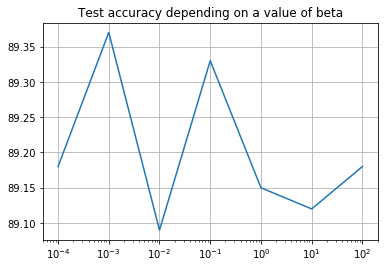

In [8]:
plt.semilogx(beta_values_list,Valid_Accuracy)
plt.grid(True)
plt.title('Test accuracy depending on a value of beta')
plt.show

In [9]:
# Now lets check the perfomance on ANN from previous section

batch_size = 128
learning_rate = 5e-1
n_hidden = 1024
beta_value = 1e-3


graph = tf.Graph()
with graph.as_default():
    
    # Input data. Exactly the same as above (two placeholders to handle baches of trainig samples)
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size*image_size))
    
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size,num_labels))
    
    beta = tf.placeholder(tf.float32)
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables
    
    weights_1 = tf.Variable(tf.truncated_normal([image_size*image_size,n_hidden]))
    bias_1 = tf.Variable(tf.zeros(n_hidden))
    
    weights_2 = tf.Variable(tf.truncated_normal([n_hidden,num_labels]))
    
    bias_2 = tf.Variable(tf.zeros(num_labels))
    
    # Compute activation at the first layer 
    
    pre_activation_1 = tf.matmul(tf_train_dataset, weights_1) + bias_1
    activation_1 = tf.nn.relu(pre_activation_1)
    
    # Now compute logits
    
    logits = tf.matmul(activation_1,weights_2) + bias_2
    
    # continue with defining loss, optimizer etc.. the same as before
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,logits=logits) + \
                          beta*(tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2)))
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    # Make predictions
    
    train_prediction = tf.nn.softmax(logits)
    
    valid_activation_1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + bias_1)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_activation_1,weights_2) + bias_2)
    
    
    test_prediction_1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + bias_1)
    test_prediction = tf.nn.softmax(tf.matmul(test_prediction_1,weights_2) + bias_2)
    

In [10]:
# Run the same iterator as above

num_steps = 3001

with tf.Session(graph=graph) as session:
    
    tf.global_variables_initializer().run()
    print("Initializer")
    
    for step in range(num_steps):
        
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset+batch_size),:]
        batch_labels = train_labels[offset:(offset+batch_size),:]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels, beta:beta_value }
        
        _, l, predictions = session.run([optimizer,loss,train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initializer
Minibatch loss at step 0: 602.644165
Minibatch accuracy: 10.2%
Validation accuracy: 35.1%
Minibatch loss at step 500: 194.979370
Minibatch accuracy: 79.7%
Validation accuracy: 81.7%
Minibatch loss at step 1000: 115.231041
Minibatch accuracy: 78.9%
Validation accuracy: 81.6%
Minibatch loss at step 1500: 68.701134
Minibatch accuracy: 78.9%
Validation accuracy: 83.2%
Minibatch loss at step 2000: 41.332603
Minibatch accuracy: 85.9%
Validation accuracy: 84.9%
Minibatch loss at step 2500: 25.205338
Minibatch accuracy: 87.5%
Validation accuracy: 85.9%
Minibatch loss at step 3000: 15.343566
Minibatch accuracy: 89.8%
Validation accuracy: 87.0%
Test accuracy: 92.9%


Accuracy increased by 3 %


# Problem 2
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches

In [11]:
# Now lets check the perfomance on ANN from previous section

batch_size = 128
learning_rate = 5e-1
n_hidden = 1024
beta_value = 1e-3


graph = tf.Graph()
with graph.as_default():
    
    # Input data. Exactly the same as above (two placeholders to handle baches of trainig samples)
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size*image_size))
    
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size,num_labels))
    
    beta = tf.placeholder(tf.float32)
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables
    
    weights_1 = tf.Variable(tf.truncated_normal([image_size*image_size,n_hidden]))
    bias_1 = tf.Variable(tf.zeros(n_hidden))
    
    weights_2 = tf.Variable(tf.truncated_normal([n_hidden,num_labels]))
    
    bias_2 = tf.Variable(tf.zeros(num_labels))
    
    # Compute activation at the first layer 
    
    pre_activation_1 = tf.matmul(tf_train_dataset, weights_1) + bias_1
    activation_1 = tf.nn.relu(pre_activation_1)
    
    # Now compute logits
    
    logits = tf.matmul(activation_1,weights_2) + bias_2
    
    # continue with defining loss, optimizer etc.. the same as before
    
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,logits=logits) + \
    #                      beta*(tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2)))
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,logits=logits))
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    # Make predictions
    
    train_prediction = tf.nn.softmax(logits)
    
    valid_activation_1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + bias_1)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_activation_1,weights_2) + bias_2)
    
    
    test_prediction_1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + bias_1)
    test_prediction = tf.nn.softmax(tf.matmul(test_prediction_1,weights_2) + bias_2)
    

Now we have only three batches each step (very small amount of data plus the regularization term is ommited)

In [12]:
# Run the same iterator as above

num_steps = 101
num_batches = 3


with tf.Session(graph=graph) as session:
    
    tf.global_variables_initializer().run()
    print("Initializer")
    
    for step in range(num_steps):
        
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset+batch_size),:]
        batch_labels = train_labels[offset:(offset+batch_size),:]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        
        feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels}
        
        #feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels, beta:beta_value}
        
        _, l, predictions = session.run([optimizer,loss,train_prediction], feed_dict=feed_dict)
        
        if (step % 2 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initializer
Minibatch loss at step 0: 348.711182
Minibatch accuracy: 8.6%
Validation accuracy: 24.6%
Minibatch loss at step 2: 1344.385498
Minibatch accuracy: 40.6%
Validation accuracy: 39.1%
Minibatch loss at step 4: 577.273010
Minibatch accuracy: 50.8%
Validation accuracy: 54.9%
Minibatch loss at step 6: 148.153214
Minibatch accuracy: 72.7%
Validation accuracy: 69.7%
Minibatch loss at step 8: 47.228714
Minibatch accuracy: 83.6%
Validation accuracy: 70.6%
Minibatch loss at step 10: 19.495886
Minibatch accuracy: 90.6%
Validation accuracy: 71.1%
Minibatch loss at step 12: 11.177982
Minibatch accuracy: 96.9%
Validation accuracy: 72.6%
Minibatch loss at step 14: 1.391552
Minibatch accuracy: 97.7%
Validation accuracy: 72.9%
Minibatch loss at step 16: 0.188792
Minibatch accuracy: 99.2%
Validation accuracy: 71.8%
Minibatch loss at step 18: 0.295226
Minibatch accuracy: 98.4%
Validation accuracy: 72.8%
Minibatch loss at step 20: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.8%
Mi

Accuracy now is around 79.5%. The network is very successful in fitting to the training set (Minibatch accuracy: 100.0%) however is pretty bad in generalization on unsee data.

# Problem 3
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides nn.dropout() for that, but you have to make sure it's only inserted during training.

In [13]:
# Now lets check the perfomance on ANN from previous section

batch_size = 128
learning_rate = 5e-1
n_hidden = 1024
beta_value = 1e-3
dropout_rate = 0.5

graph = tf.Graph()
with graph.as_default():
    
    # Input data. Exactly the same as above (two placeholders to handle baches of trainig samples)
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size*image_size))
    
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size,num_labels))
    
    beta = tf.placeholder(tf.float32)
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables
    
    weights_1 = tf.Variable(tf.truncated_normal([image_size*image_size,n_hidden]))
    bias_1 = tf.Variable(tf.zeros(n_hidden))
    
    weights_2 = tf.Variable(tf.truncated_normal([n_hidden,num_labels]))
    
    bias_2 = tf.Variable(tf.zeros(num_labels))
    
    # Compute activation at the first layer 
    
    pre_activation_1 = tf.matmul(tf_train_dataset, weights_1) + bias_1
    activation_1 = tf.nn.relu(pre_activation_1)
    
    # Introduce dropout
    
    drop_1 = tf.nn.dropout(activation_1,dropout_rate)
    
    # Now compute logits
    
    logits = tf.matmul(drop_1,weights_2) + bias_2
    
    # continue with defining loss, optimizer etc.. the same as before
    
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,logits=logits) + \
    #                      beta*(tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2)))
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,logits=logits))
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    # Make predictions
    
    train_prediction = tf.nn.softmax(logits)
    
    valid_activation_1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + bias_1)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_activation_1,weights_2) + bias_2)
    
    
    test_prediction_1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + bias_1)
    test_prediction = tf.nn.softmax(tf.matmul(test_prediction_1,weights_2) + bias_2)
    
    

In [14]:
# Run the same iterator as above

num_steps = 101
num_batches = 3


with tf.Session(graph=graph) as session:
    
    tf.global_variables_initializer().run()
    print("Initializer")
    
    for step in range(num_steps):
        
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset+batch_size),:]
        batch_labels = train_labels[offset:(offset+batch_size),:]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        
        feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels}
        
        #feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels, beta:beta_value}
        
        _, l, predictions = session.run([optimizer,loss,train_prediction], feed_dict=feed_dict)
        
        if (step % 2 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initializer
Minibatch loss at step 0: 539.126648
Minibatch accuracy: 5.5%
Validation accuracy: 28.6%
Minibatch loss at step 2: 847.733765
Minibatch accuracy: 56.2%
Validation accuracy: 42.2%
Minibatch loss at step 4: 499.749695
Minibatch accuracy: 46.9%
Validation accuracy: 57.5%
Minibatch loss at step 6: 306.406586
Minibatch accuracy: 61.7%
Validation accuracy: 65.7%
Minibatch loss at step 8: 107.616318
Minibatch accuracy: 81.2%
Validation accuracy: 67.0%
Minibatch loss at step 10: 51.464756
Minibatch accuracy: 81.2%
Validation accuracy: 73.0%
Minibatch loss at step 12: 36.775883
Minibatch accuracy: 88.3%
Validation accuracy: 73.2%
Minibatch loss at step 14: 30.300474
Minibatch accuracy: 85.9%
Validation accuracy: 74.5%
Minibatch loss at step 16: 8.583896
Minibatch accuracy: 90.6%
Validation accuracy: 74.0%
Minibatch loss at step 18: 24.714993
Minibatch accuracy: 89.1%
Validation accuracy: 75.2%
Minibatch loss at step 20: 5.510467
Minibatch accuracy: 94.5%
Validation accuracy: 75.6%
M

Now it became more difficult to achieve 100% of accuracy on the mini-batches. As a result test accuracy is also improved by 4%. It means that the net has more abilities to generalize. However, only 2% improvement is a small value, hence there is a big room for improvement to increase the resulting accuracy.

# Problem 4

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is 97.1%.

One avenue you can explore is to add multiple layers. Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

In [43]:
# Previous experience tells us to use at least three hidden layers, let's start with that

n_hidden_nodes_1 = 1024
n_hidden_nodes_2 = 256
n_hidden_nodes_3 = 128


batch_size = 128
learning_rate_value = 0.5
beta_value = 1e-3
dropout_rate = 0.5


graph = tf.Graph()
with graph.as_default():
    
    # Input data. Exactly the same as above (two placeholders to handle baches of trainig samples)
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size,num_labels))
    
    #beta = tf.placeholder(tf.float32)
    
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    global_step = tf.Variable(0)
    
    # Variables
    
    weights_1 = tf.Variable(tf.truncated_normal([image_size*image_size,n_hidden_nodes_1],
                                                stddev=np.sqrt(2.0 / (image_size * image_size))))
    weights_2 = tf.Variable(tf.truncated_normal([n_hidden_nodes_1,n_hidden_nodes_2],
                                                stddev=np.sqrt(2.0 / (image_size * image_size))))
    weights_3 = tf.Variable(tf.truncated_normal([n_hidden_nodes_2,n_hidden_nodes_3],
                                                stddev=np.sqrt(2.0 / (image_size * image_size))))
    weights_4 = tf.Variable(tf.truncated_normal([n_hidden_nodes_3,num_labels],
                                                stddev=np.sqrt(2.0 / (image_size * image_size))))
    
    
    
    bias_1 = tf.Variable(tf.zeros(n_hidden_nodes_1))
    bias_2 = tf.Variable(tf.zeros(n_hidden_nodes_2))
    bias_3 = tf.Variable(tf.zeros(n_hidden_nodes_3))
    bias_4 = tf.Variable(tf.zeros(num_labels))
    
    
    # Compute activations at all layers + dropout
    
    pre_activation_1 = tf.matmul(tf_train_dataset, weights_1) + bias_1
    activation_1 = tf.nn.relu(pre_activation_1)
    drop_1 = tf.nn.dropout(activation_1,dropout_rate)
    
    pre_activation_2 = tf.matmul(drop_1, weights_2) + bias_2
    activation_2 = tf.nn.relu(pre_activation_2)
    drop_2 = tf.nn.dropout(activation_2,dropout_rate)
    
    pre_activation_3 = tf.matmul(drop_2, weights_3) + bias_3
    activation_3 = tf.nn.relu(pre_activation_3)
    drop_3 = tf.nn.dropout(activation_3,dropout_rate)
    
    # Now compute logits
    
    logits = tf.matmul(drop_3,weights_4) + bias_4
    
    # continue with defining loss, optimizer etc.. the same as before
    
    #loss_l2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels,logits=logits) + \
    #                      beta*(tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2)))
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=tf_train_labels))
    
    #decay every 5000 steps with a base of 0.8
    
    learning_rate = tf.train.exponential_decay(0.5, global_step, 5000, 0.80, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
    # Make predictions
    
    train_prediction = tf.nn.softmax(logits)
    
    valid_activation_1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + bias_1)
    valid_activation_2 = tf.nn.relu(tf.matmul(valid_activation_1, weights_2) + bias_2)
    valid_activation_3 = tf.nn.relu(tf.matmul(valid_activation_2, weights_3) + bias_3)
    
    valid_prediction = tf.nn.softmax(tf.matmul(valid_activation_3,weights_4) + bias_4)
    
    
    test_prediction_1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + bias_1)
    test_prediction_2 = tf.nn.relu(tf.matmul(test_prediction_1, weights_2) + bias_2)
    test_prediction_3 = tf.nn.relu(tf.matmul(test_prediction_2, weights_3) + bias_3)
    
    test_prediction = tf.nn.softmax(tf.matmul(test_prediction_3,weights_4) + bias_4)
    
    

In [45]:
# Run the same iterator as above

num_steps = 25001

with tf.Session(graph=graph) as session:
    
    tf.initialize_all_variables().run()
    print("Initializer")
    
    for step in range(num_steps):
        
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        #offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset+batch_size),:]
        batch_labels = train_labels[offset:(offset+batch_size),:]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        
        feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels}
        
        #feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels, beta:beta_value}
        
        _, l, predictions = session.run([optimizer,loss,train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    

Initializer
Minibatch loss at step 0: 2.352903
Minibatch accuracy: 13.3%
Validation accuracy: 15.1%
Minibatch loss at step 500: 0.688872
Minibatch accuracy: 75.0%
Validation accuracy: 84.4%
Minibatch loss at step 1000: 0.522505
Minibatch accuracy: 82.0%
Validation accuracy: 84.8%
Minibatch loss at step 1500: 0.558192
Minibatch accuracy: 80.5%
Validation accuracy: 86.0%
Minibatch loss at step 2000: 0.506258
Minibatch accuracy: 85.2%
Validation accuracy: 86.2%
Minibatch loss at step 2500: 0.565487
Minibatch accuracy: 82.0%
Validation accuracy: 86.3%
Minibatch loss at step 3000: 0.374906
Minibatch accuracy: 89.8%
Validation accuracy: 87.0%
Minibatch loss at step 3500: 0.349360
Minibatch accuracy: 92.2%
Validation accuracy: 86.8%
Minibatch loss at step 4000: 0.449336
Minibatch accuracy: 83.6%
Validation accuracy: 87.1%
Minibatch loss at step 4500: 0.419907
Minibatch accuracy: 88.3%
Validation accuracy: 87.3%
Minibatch loss at step 5000: 0.533367
Minibatch accuracy: 83.6%
Validation accurac